In [3]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import *
from keras.utils import np_utils
%matplotlib inline

In [4]:
cd "C:\Users\711667\OneDrive - hull.ac.uk\AI\Assessment\Cefas_smartbuoy"

C:\Users\711667\OneDrive - hull.ac.uk\AI\Assessment\Cefas_smartbuoy


In [5]:
df = pd.read_csv('clean_ext_data.csv', parse_dates = ['dateTime'])
df = df.set_index('dateTime')
df = df.drop('kd', axis = 1)
df = df.dropna()

phase_0 = df.loc[df['phase'] == 0, :].copy()
X = phase_0.drop(['fluors', 'phase'], axis = 1).copy()
y = phase_0['fluors'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# standardize the data
scaler = StandardScaler()
#train the scaler on the training data
X_train = scaler.fit_transform(X_train)
#apply the scaler to the test data sets
X_test = scaler.transform(X_test)
X = scaler.transform(X)

phase_1 = df.loc[df['phase'] > 0, :].copy()
X_1 = phase_1.drop(['fluors', 'phase'], axis = 1).copy()
y_1 = phase_1.loc[:, 'fluors'].copy()
scaler = StandardScaler()
X_1 = scaler.fit_transform(X_1)

Creating a simple basiline neural network

In [6]:
baseline_model = Sequential()
baseline_model.add(Dense(units = 10, activation = "relu", input_shape = (4, )))
baseline_model.add(Dense(1, activation = "relu"))
baseline_model.summary()
baseline_model.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ['mean_squared_error'])
no_epochs = 10
history = baseline_model.fit(X_train, y_train, batch_size = 50, epochs = no_epochs, verbose = 0, validation_data = (X_test, y_test))
#score = model.evaluate(X_test, y_test, verbose = 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [7]:
pred_train = baseline_model.predict(X_train)
print(np.sqrt(mean_squared_error(y_train, pred_train)))
pred_test = baseline_model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, pred_test)))
y_pred = baseline_model.predict(X)
print(np.sqrt(mean_squared_error(y, y_pred)))

940/940 [==============================] - 1s 597us/step
1.599094303281397
403/403 [==============================] - 0s 562us/step
1.595580726841698
1343/1343 [==============================] - 1s 547us/step
1.5980410174717812


C:\Users\711667\AppData\Local\Temp\ipykernel_14312\1629238641.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


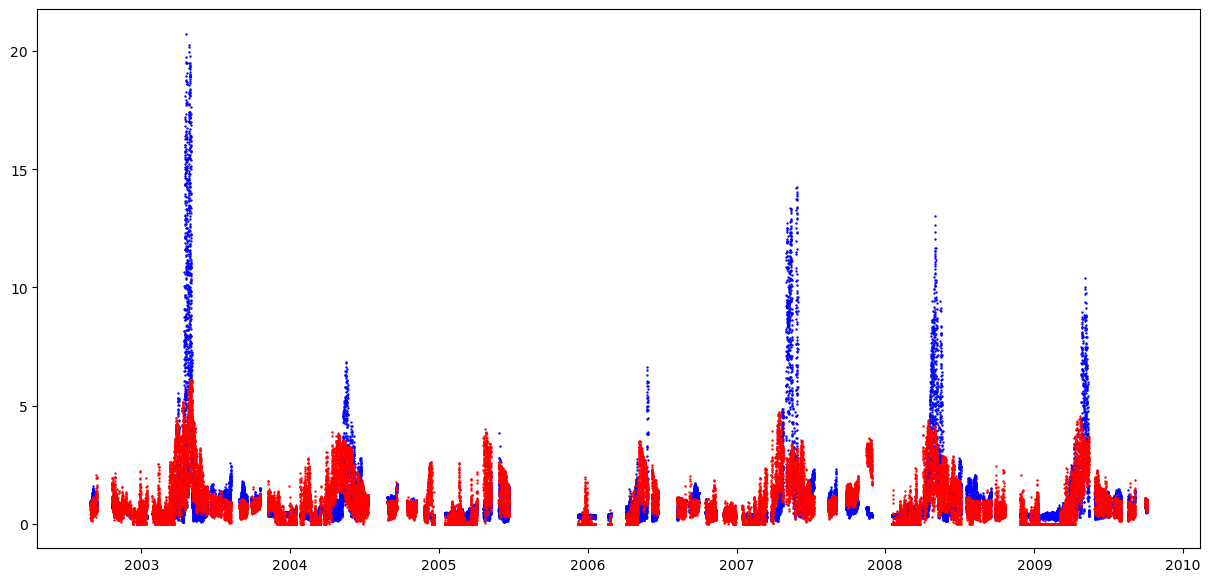

In [8]:
phase_0.loc[:, 'y_pred'] = y_pred
fig, ax = plt.subplots(figsize = (15, 7))
ax.scatter(phase_0.index, phase_0['fluors'], s = 0.5, color = 'blue')
ax.scatter(phase_0.index, phase_0['y_pred'], s = 0.5, color = 'red')
#fig.savefig('predictions.png')
fig.show()

In [9]:
model = keras.models.load_model('b2e20_1.h5',compile = False)
dummy_regr = DummyRegressor(strategy = "mean")
dummy_regr.fit(X_train, y_train)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
poly_reg = PolynomialFeatures(degree = 3, include_bias = False)
X_poly = poly_reg.fit_transform(X_train)
poly_reg.fit(X_poly, y_train)
lin_reg2 = LinearRegression(fit_intercept = False)
lin_reg2.fit(X_poly, y_train)

pred_train = model.predict(X_train)
dummy_pred_train = dummy_regr.predict(X_train)
lin_pred_train = lin_reg.predict(X_train)
poly_pred_train = lin_reg2.predict(poly_reg.fit_transform(X_train))

pred_test = model.predict(X_test)
dummy_pred_test = dummy_regr.predict(X_test)
lin_pred_test = lin_reg.predict(X_test)
poly_pred_test = lin_reg2.predict(poly_reg.fit_transform(X_test))

fluors_pred = model.predict(X)
dummy_fluors_pred = dummy_regr.predict(X)
lin_fluors_pred = lin_reg.predict(X)
poly_fluors_pred = lin_reg2.predict(poly_reg.fit_transform(X))

fluors_pred_1 = model.predict(X_1)
dummy_fluors_pred_1 = dummy_regr.predict(X_1)
lin_fluors_pred_1 = lin_reg.predict(X_1)
poly_fluors_pred_1 = lin_reg2.predict(poly_reg.fit_transform(X_1))

phase_0.loc[:, 'fluors_pred'] = fluors_pred
phase_0.loc[:, 'dummy_fluors_pred'] = dummy_fluors_pred
phase_0.loc[:, 'lin_fluors_pred'] = lin_fluors_pred
phase_0.loc[:, 'poly_fluors_pred'] = poly_fluors_pred
phase_1.loc[:, 'fluors_pred'] = fluors_pred_1
phase_1.loc[:, 'dummy_fluors_pred'] = dummy_fluors_pred_1
phase_1.loc[:, 'lin_fluors_pred'] = lin_fluors_pred_1
phase_1.loc[:, 'poly_fluors_pred'] = poly_fluors_pred_1

1904/1904 [==============================] - 2s 1ms/step


In [10]:
print(f'Training RMS error: {np.sqrt(mean_squared_error(y_train, pred_train))}')
print(f'Dummy Training RMS error: {np.sqrt(mean_squared_error(y_train, dummy_pred_train))}')
print(f'Linear Training RMS error: {np.sqrt(mean_squared_error(y_train, lin_pred_train))}')
print(f'Polynomial Training RMS error: {np.sqrt(mean_squared_error(y_train, poly_pred_train))}')
print('')
print(f'Training r2 score: {r2_score(y_train, pred_train)}')
print(f'Dummy Training r2 score: {r2_score(y_train, dummy_pred_train)}')
print(f'Linear Training r2 score: {r2_score(y_train, lin_pred_train)}')
print(f'Polynomial Training r2 score: {r2_score(y_train, poly_pred_train)}')
print('')
print(f'Training MAE error: {median_absolute_error(y_train, pred_train)}')
print(f'Dummy Training MAE error: {median_absolute_error(y_train, dummy_pred_train)}')
print(f'Linear Training MAE error: {median_absolute_error(y_train, lin_pred_train)}')
print(f'Polynomial Training MAE error: {median_absolute_error(y_train, poly_pred_train)}')
print('')
print(f'Training MAP error: {100*mean_absolute_percentage_error(y_train, pred_train)}')
print(f'Dummy Training MAP error: {100*mean_absolute_percentage_error(y_train, dummy_pred_train)}')
print(f'Linear Training MAP error: {100*mean_absolute_percentage_error(y_train, lin_pred_train)}')
print(f'Polynomial Training MAP error: {100*mean_absolute_percentage_error(y_train, poly_pred_train)}')

Training RMS error: 1.196214127103159
Dummy Training RMS error: 1.9010678603688378
Linear Training RMS error: 1.7836886216542496
Polynomial Training RMS error: 1.6759814680017109

Training r2 score: 0.6040661665928018
Dummy Training r2 score: 0.0
Linear Training r2 score: 0.11967538702173641
Polynomial Training r2 score: 0.22278140076714514

Training MAE error: 0.21218995094299262
Dummy Training MAE error: 0.6287229497490803
Linear Training MAE error: 0.48695089400385616
Polynomial Training MAE error: 0.47944827245431687

Training MAP error: 71.81627209226804
Dummy Training MAP error: 124.98603884703927
Linear Training MAP error: 117.2411979682967
Polynomial Training MAP error: 109.93822754785366


In [11]:
print(f'Test RMS error: {np.sqrt(mean_squared_error(y_test, pred_test))}')
print(f'Dummy Test RMS error: {np.sqrt(mean_squared_error(y_test, dummy_pred_test))}')
print(f'Linear Test RMS error: {np.sqrt(mean_squared_error(y_test, lin_pred_test))}')
print(f'Polynomial Test RMS error: {np.sqrt(mean_squared_error(y_test, poly_pred_test))}')
print('')
print(f'Test r2 score: {r2_score(y_test, pred_test)}')
print(f'Dummy Test r2 score: {r2_score(y_test, dummy_pred_test)}')
print(f'Linear Test r2 score: {r2_score(y_test, lin_pred_test)}')
print(f'Polynomial Test r2 score: {r2_score(y_test, poly_pred_test)}')
print('')
print(f'Test MAE error: {median_absolute_error(y_test, pred_test)}')
print(f'Dummy Test MAE error: {median_absolute_error(y_test, dummy_pred_test)}')
print(f'Linear Test MAE error: {median_absolute_error(y_test, lin_pred_test)}')
print(f'Polynomial Test MAE error: {median_absolute_error(y_test, poly_pred_test)}')
print('')
print(f'Test MAP error: {100*mean_absolute_percentage_error(y_test, pred_test)}')
print(f'Dummy Test MAP error: {100*mean_absolute_percentage_error(y_test, dummy_pred_test)}')
print(f'Linear Test MAP error: {100*mean_absolute_percentage_error(y_test, lin_pred_test)}')
print(f'Polynomial Test MAP error: {100*mean_absolute_percentage_error(y_test, poly_pred_test)}')

Test RMS error: 1.183252277041415
Dummy Test RMS error: 1.8647719433365813
Linear Test RMS error: 1.7597248501738163
Polynomial Test RMS error: 1.6754235719144819

Test r2 score: 0.5973429998681059
Dummy Test r2 score: -7.370503184223054e-05
Linear Test r2 score: 0.10942584006411604
Polynomial Test r2 score: 0.19270958051690212

Test MAE error: 0.21248807907104472
Dummy Test MAE error: 0.6237229497490804
Linear Test MAE error: 0.4836435826105054
Polynomial Test MAE error: 0.49109861300918345

Test MAP error: 71.61924456169073
Dummy Test MAP error: 125.08764897811162
Linear Test MAP error: 116.70352818113136
Polynomial Test MAP error: 110.95863157135129


In [12]:
print(f'Overall pre-construcion RMS error: {np.sqrt(mean_squared_error(y, fluors_pred))}')
print(f'Dummy Overall pre-construcion RMS error: {np.sqrt(mean_squared_error(y, dummy_fluors_pred))}')
print(f'Linear Overall pre-construcion RMS error: {np.sqrt(mean_squared_error(y, lin_fluors_pred))}')
print(f'Polynomial Overall pre-construcion RMS error: {np.sqrt(mean_squared_error(y, poly_fluors_pred))}')
print('')
print(f'Overall pre-construcion r2 score: {r2_score(y, fluors_pred)}')
print(f'Dummy Overall pre-construcion r2 score: {r2_score(y, dummy_fluors_pred)}')
print(f'Linear Overall pre-construcion r2 score: {r2_score(y, lin_fluors_pred)}')
print(f'Polynomial Overall pre-construcion r2 score: {r2_score(y, poly_fluors_pred)}')
print('')
print(f'Overall pre-construcion MAE error: {median_absolute_error(y, fluors_pred)}')
print(f'Dummy Overall pre-construcion MAE error: {median_absolute_error(y, dummy_fluors_pred)}')
print(f'Linear Overall pre-construcion MAE error: {median_absolute_error(y, lin_fluors_pred)}')
print(f'Polynomial Overall pre-construcion MAE error: {median_absolute_error(y, poly_fluors_pred)}')

Overall pre-construcion RMS error: 1.1923402770441707
Dummy Overall pre-construcion RMS error: 1.8902520130141895
Linear Overall pre-construcion RMS error: 1.7765332648057681
Polynomial Overall pre-construcion RMS error: 1.675814114782288

Overall pre-construcion r2 score: 0.6021092761888833
Dummy Overall pre-construcion r2 score: -6.4556903487389405e-06
Linear Overall pre-construcion r2 score: 0.11669625256705196
Polynomial Overall pre-construcion r2 score: 0.21401352445355903

Overall pre-construcion MAE error: 0.21226992607116701
Dummy Overall pre-construcion MAE error: 0.6287229497490796
Linear Overall pre-construcion MAE error: 0.4858885057074884
Polynomial Overall pre-construcion MAE error: 0.4827890822983861


In [13]:
print(f'Overall post-construction RMS error {np.sqrt(mean_squared_error(y_1, fluors_pred_1))}')
print(f'Dummy Overall post-construction RMS error {np.sqrt(mean_squared_error(y_1, dummy_fluors_pred_1))}')
print(f'Linear Overall post-construction RMS error {np.sqrt(mean_squared_error(y_1, lin_fluors_pred_1))}')
print(f'Polynomial Overall post-construction RMS error {np.sqrt(mean_squared_error(y_1, poly_fluors_pred_1))}')
print('')
print(f'Overall post-construction r2 score {r2_score(y_1, fluors_pred_1)}')
print(f'Dummy Overall post-construction r2 score {r2_score(y_1, dummy_fluors_pred_1)}')
print(f'Linear Overall post-construction r2 score {r2_score(y_1, lin_fluors_pred_1)}')
print(f'Polynomial Overall post-construction r2 score {r2_score(y_1, poly_fluors_pred_1)}')
print('')
print(f'Overall post-construction MAE error {median_absolute_error(y_1, fluors_pred_1)}')
print(f'Dummy Overall post-construction MAE error {median_absolute_error(y_1, dummy_fluors_pred_1)}')
print(f'Linear Overall post-construction MAE error {median_absolute_error(y_1, lin_fluors_pred_1)}')
print(f'Polynomial Overall post-construction MAE error {median_absolute_error(y_1, poly_fluors_pred_1)}')

Overall post-construction RMS error 1.4135170037876932
Dummy Overall post-construction RMS error 1.307951947747019
Linear Overall post-construction RMS error 1.2580687885486317
Polynomial Overall post-construction RMS error 1.391065763720075

Overall post-construction r2 score -0.20821842925550027
Dummy Overall post-construction r2 score -0.034491578093298836
Linear Overall post-construction r2 score 0.04291136845096555
Polynomial Overall post-construction r2 score -0.17014237153737644

Overall post-construction MAE error 0.31741724967956486
Dummy Overall post-construction MAE error 0.6637229497490804
Linear Overall post-construction MAE error 0.5412200849971343
Polynomial Overall post-construction MAE error 0.5442134663431328


C:\Users\711667\AppData\Local\Temp\ipykernel_14312\92902749.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


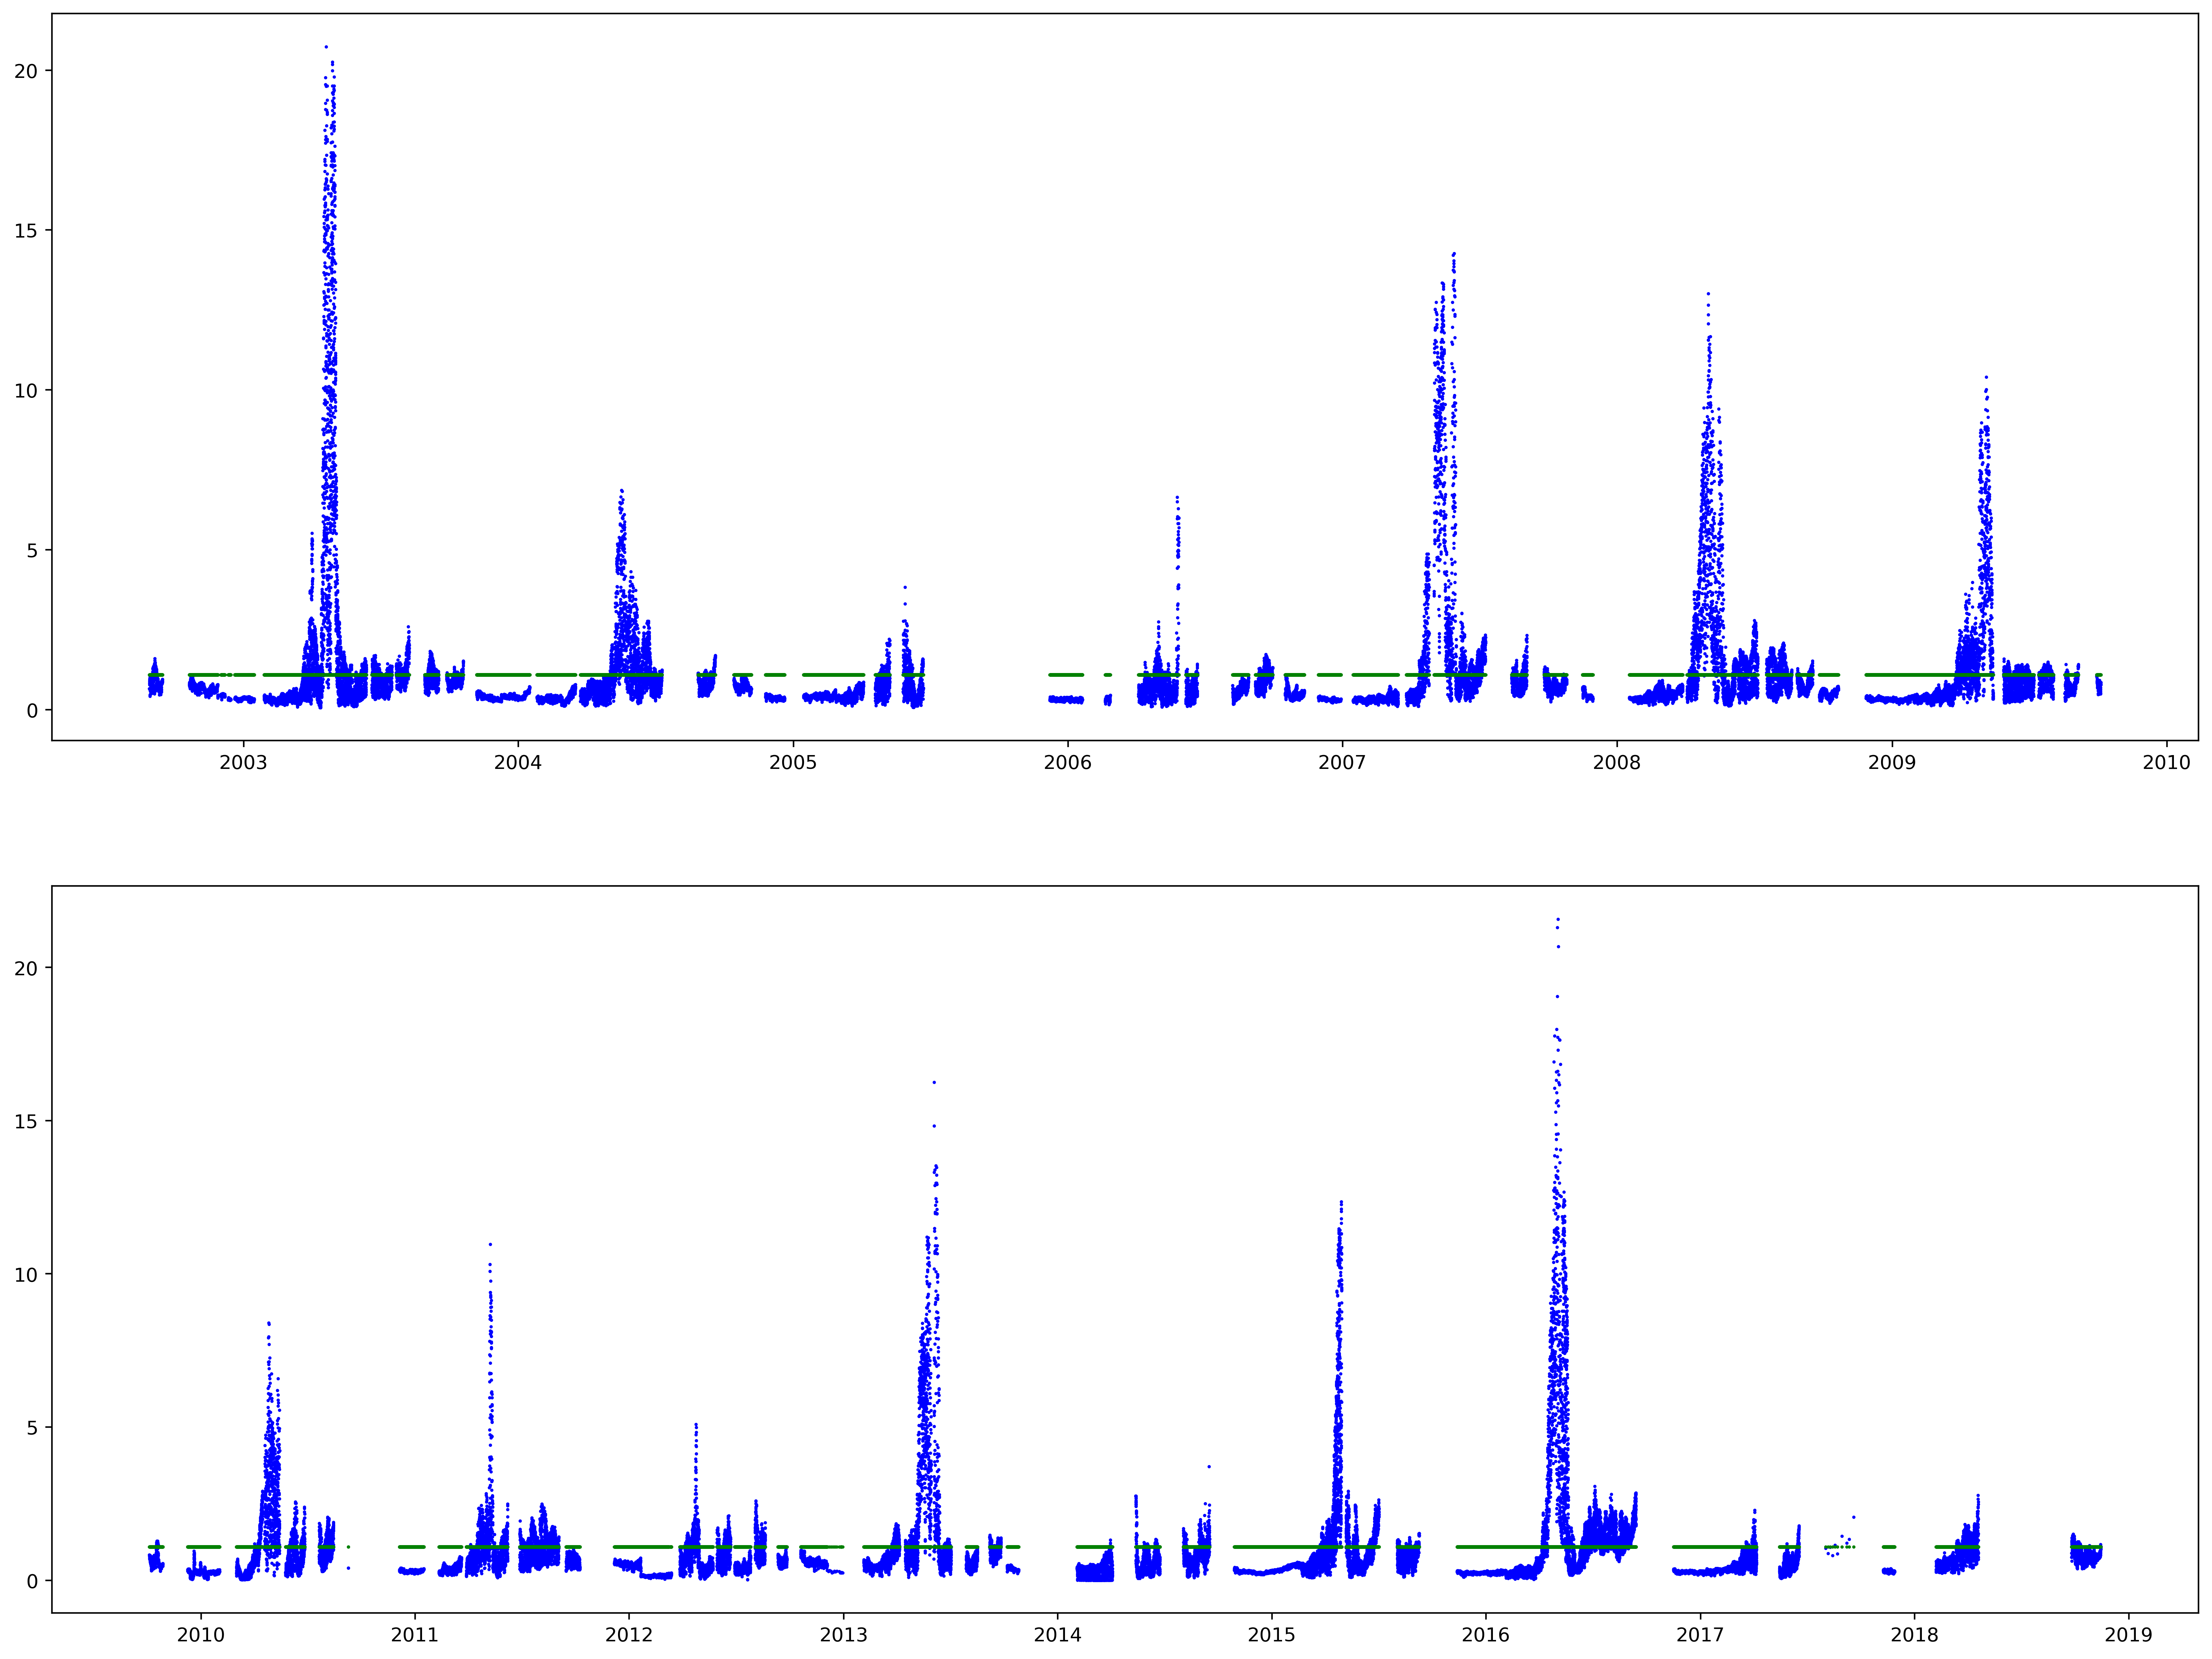

In [14]:
fig, ax = plt.subplots(2,1, figsize = (20, 15), dpi = 400)
ax[0].scatter(phase_0.index, phase_0['fluors'], s = 0.5, color = 'blue')
# ax[0].scatter(phase_0.index, phase_0['fluors_pred'], s = 0.5, color = 'red', alpha = 0.6)
# ax[0].scatter(phase_0.index, phase_0['lin_fluors_pred'], s = 0.5, color = 'orange')
# ax[0].scatter(phase_0.index, phase_0['poly_fluors_pred'], s = 0.5, color = 'purple')
ax[0].scatter(phase_0.index, phase_0['dummy_fluors_pred'], s = 0.5, color = 'green')
ax[1].scatter(phase_1.index, phase_1['fluors'], s = 0.5, color = 'blue')
# ax[1].scatter(phase_1.index, phase_1['fluors_pred'], s = 0.5, color = 'red', alpha = 0.6)
# ax[1].scatter(phase_1.index, phase_1['lin_fluors_pred'], s = 0.5, color = 'orange')
# ax[1].scatter(phase_1.index, phase_1['poly_fluors_pred'], s = 0.5, color = 'purple')
ax[1].scatter(phase_1.index, phase_1['dummy_fluors_pred'], s = 0.5, color = 'green')
#fig.savefig('model_predictions.png', dpi = 400)
fig.show()

In [18]:
def scatterplot(x,y):# Read data

    # linear regression of y on x (scipy)

    import scipy.stats as stats
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    from scipy.stats import gaussian_kde
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

    # plot linear regression

    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    fig, ax = plt.subplots(figsize=(7,6),dpi=100)
    maxNum = max(x)
    minNum = min(x)
    ax.plot(x, x, color='blue', linewidth=1,label = '1:1 line')#reference line
    ax.plot(x, intercept + slope*x, 'r', label='fitted line y = {:.2f}x + {:.2f}'.format(slope,intercept))
    ax.legend()
    # ax.set_xlabel('Buoy Temp')
    # ax.set_ylabel('CMEMS SST')
    plt.xlim(minNum, maxNum)
    plt.ylim(minNum, maxNum)
    #Least squares fit

    xcord = x
    ycord = y

    m = ((xcord*ycord).mean() - xcord.mean()* ycord.mean())/(pow(xcord,2).mean()-pow(xcord.mean(),2))

    c = ycord.mean() - m*xcord.mean()
    # Plot
    y1=m*x+c  
    scatter=ax.scatter(x,y,marker='o',c=z,edgecolors='none',s=15,label='LST',cmap='Spectral_r')
    divider=make_axes_locatable(ax)
    cax = divider.append_axes("right",size="3%",pad=0.1)
    cbar = fig.colorbar(scatter, cax=cax, label='frequency')
    cbar = fig.colorbar(scatter,cax=cax,extend='both',aspect=30,fraction=.03,pad=0.01)

    # plt.savefig('plot82.1.png',dpi=800,bbox_inches='tight',pad_inches=0)
    plt.show()

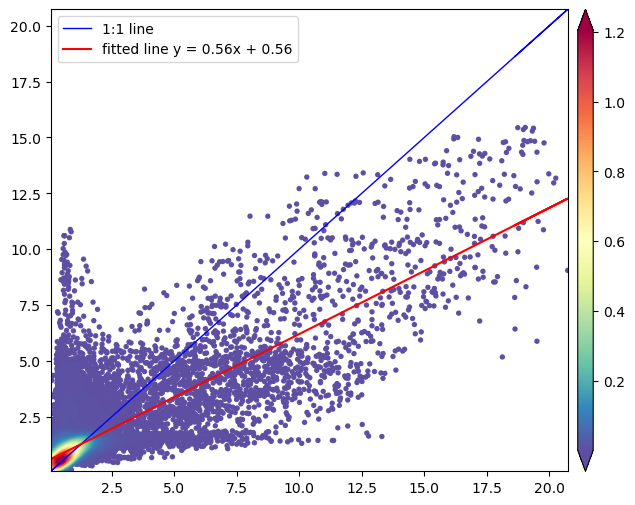

In [19]:
# phase_0['fluors'] vs phase_0['fluors_pred'] (Training set)
scatterplot(phase_0['fluors'], phase_0['fluors_pred'])

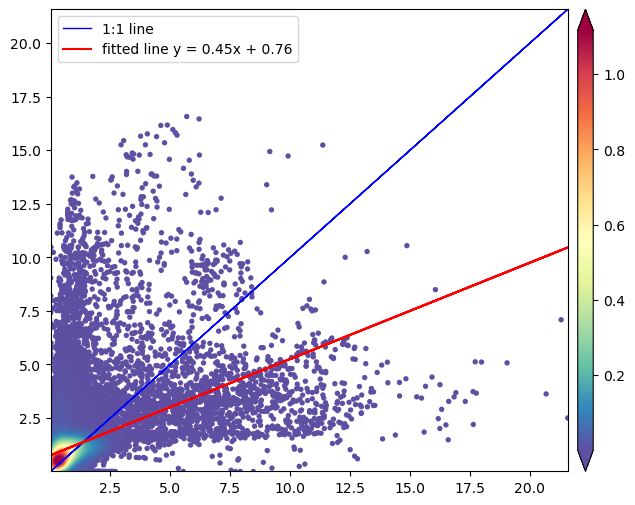

In [20]:
# phase_1['fluors'] vs phase_1['fluors_pred'] (Test set)
scatterplot(phase_1['fluors'], phase_1['fluors_pred'])

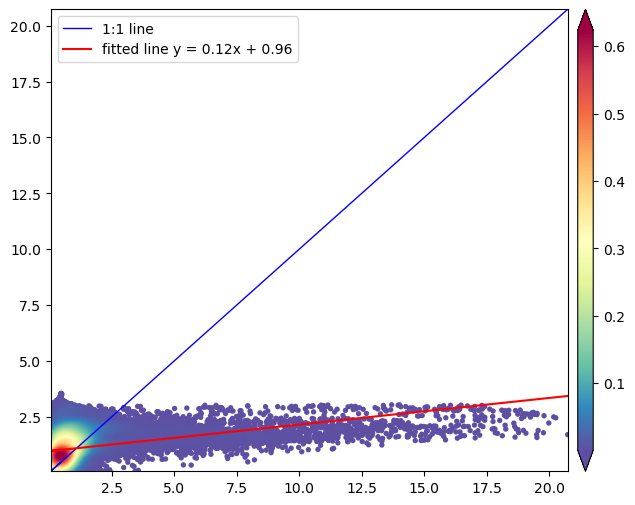

In [21]:
# phase_0['fluors'] vs phase_0['lin_fluors_pred'] (Training set)
scatterplot(phase_0['fluors'], phase_0['lin_fluors_pred'])

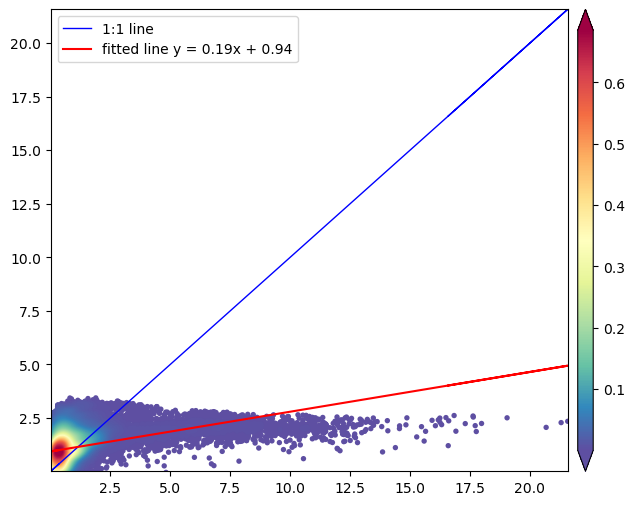

In [22]:
# phase_1['fluors'] vs phase_1['lin_fluors_pred'] (Test set)
scatterplot(phase_1['fluors'], phase_1['lin_fluors_pred'])

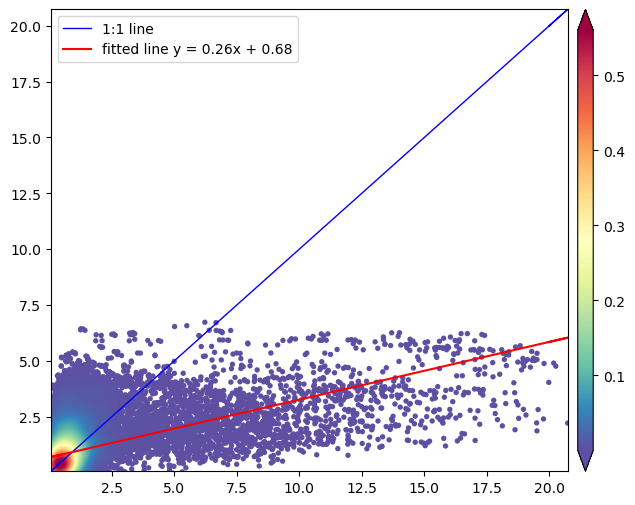

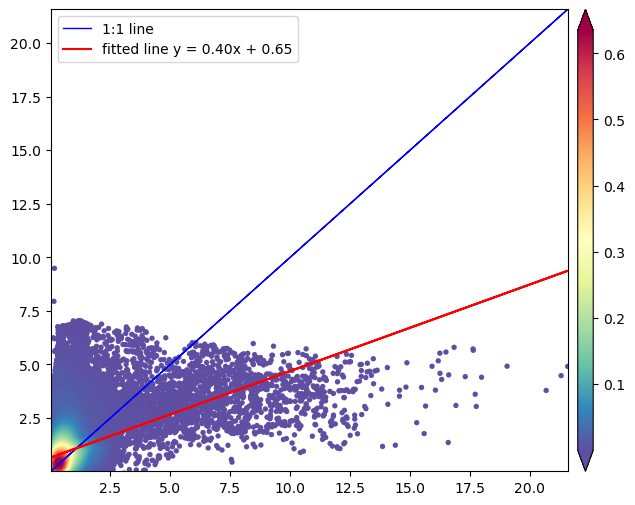

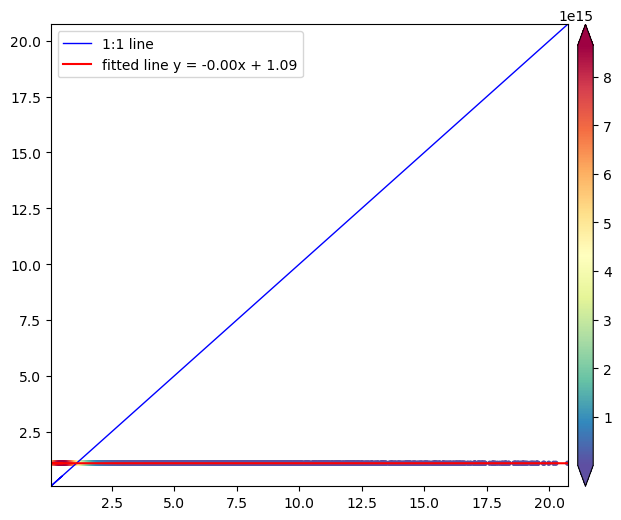

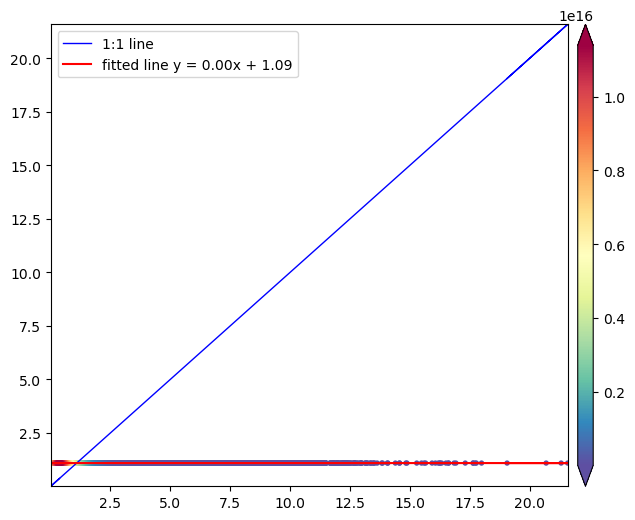

In [23]:
# phase_0['fluors'] vs phase_0['poly_fluors_pred'] (Training set)
scatterplot(phase_0['fluors'], phase_0['poly_fluors_pred'])

# phase_1['fluors'] vs phase_1['poly_fluors_pred'] (Test set)
scatterplot(phase_1['fluors'], phase_1['poly_fluors_pred'])

# phase_0['fluors'] vs phase_0['dummy_fluors_pred'] (Training set)
scatterplot(phase_0['fluors'], phase_0['dummy_fluors_pred'])

# phase_1['fluors'] vs phase_1['dummy_fluors_pred'] (Test set)
scatterplot(phase_1['fluors'], phase_1['dummy_fluors_pred'])
